In [1]:
from sklearn import set_config
from numpy.random import seed
from tensorflow import keras
from keras import backend as K, callbacks, layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

from sklearn.base import TransformerMixin, BaseEstimator
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import numpy as np

print("Tensorflow version: " + tf.__version__)
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=14, titlepad=10)
%matplotlib inline
warnings.filterwarnings('ignore')
seed(42)
tf.random.set_seed(42)
set_config(display='diagram')


Tensorflow version: 2.10.0


Data input


In [2]:
df = pd.read_csv('input/train.csv', sep = ';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6714 entries, 0 to 6713
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6714 non-null   float64
 1   volatile acidity      6714 non-null   float64
 2   citric acid           6714 non-null   float64
 3   residual sugar        6714 non-null   float64
 4   chlorides             6714 non-null   float64
 5   free sulfur dioxide   6714 non-null   int64  
 6   total sulfur dioxide  6714 non-null   int64  
 7   density               6714 non-null   float64
 8   pH                    6714 non-null   float64
 9   sulphates             6714 non-null   float64
 10  alcohol               6714 non-null   float64
 11  quality               6714 non-null   int64  
 12  type                  6714 non-null   object 
dtypes: float64(9), int64(3), object(1)
memory usage: 682.0+ KB


In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,6.6,0.3,0.36,1.2,0.035,43,126,0.9909,3.01,0.63,11.4,6,white
1,7.7,0.5,0.26,1.9,0.062,9,31,0.9966,3.39,0.64,9.6,5,red
2,8.4,0.5,0.35,2.9,0.076,21,127,0.9976,3.23,0.63,9.2,5,red
3,7.5,0.4,0.33,5.0,0.045,30,131,0.9942,3.32,0.44,10.9,6,white
4,6.4,0.2,0.25,20.2,0.083,35,157,0.9998,3.17,0.50,9.1,5,white


In [5]:
df.isnull().values.any()

False

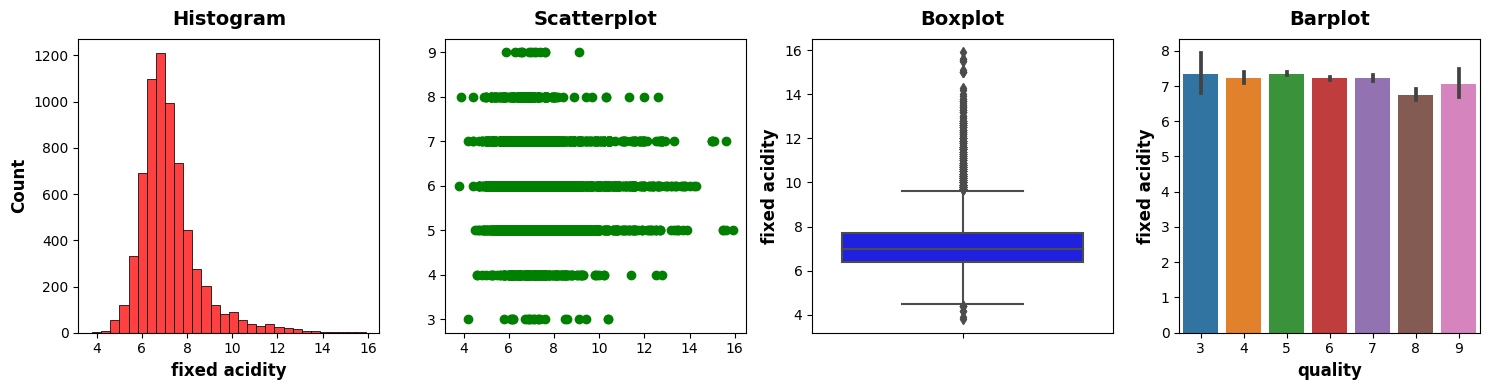

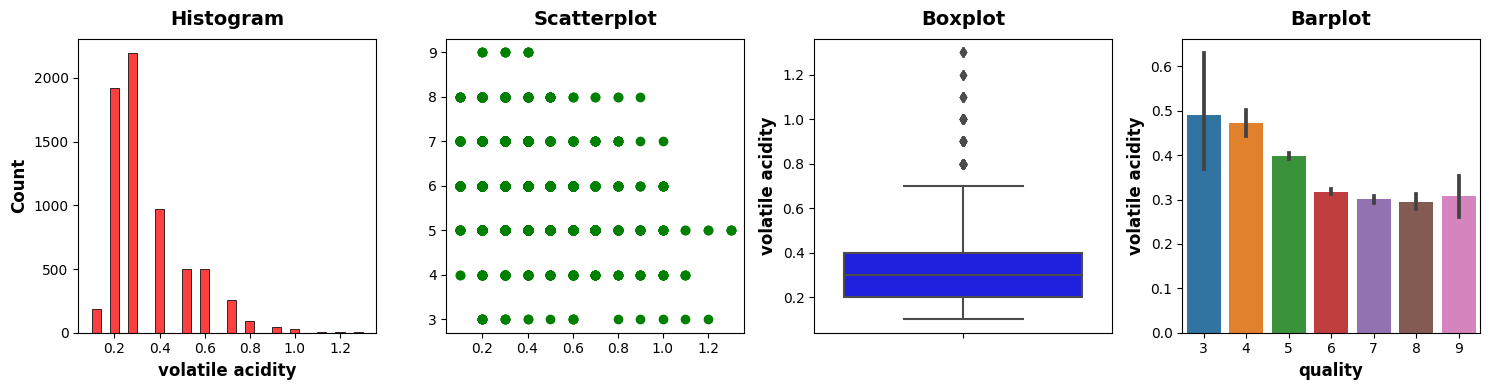

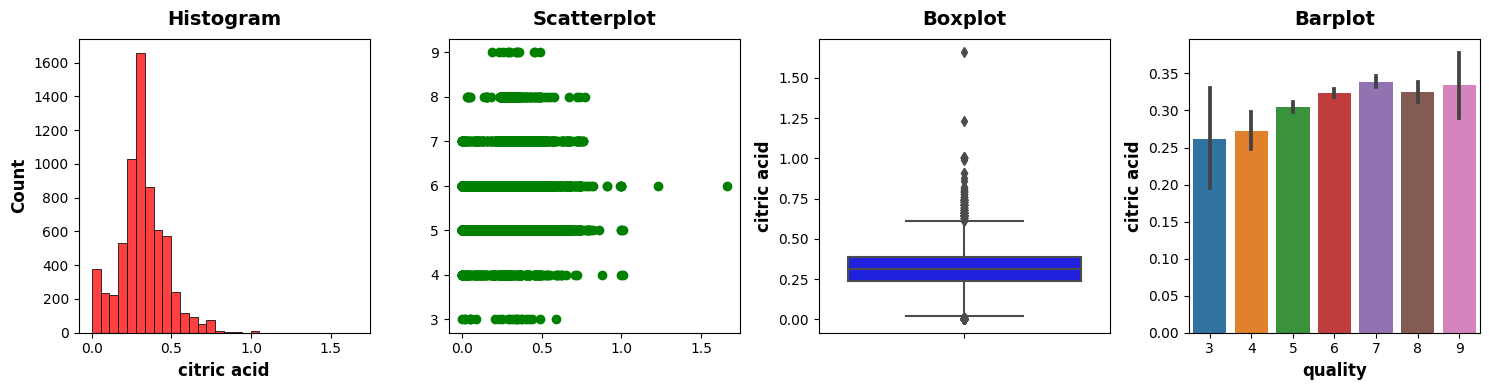

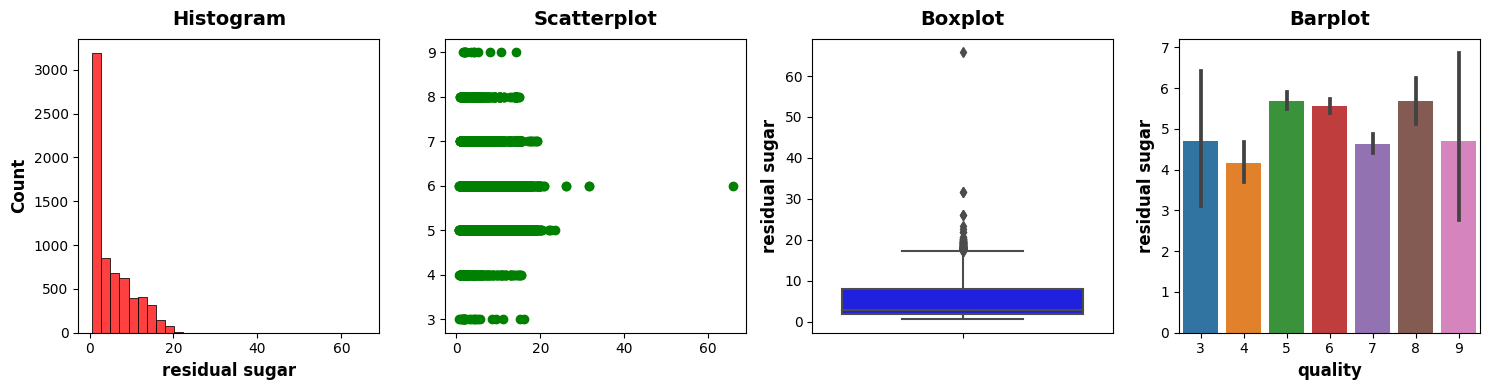

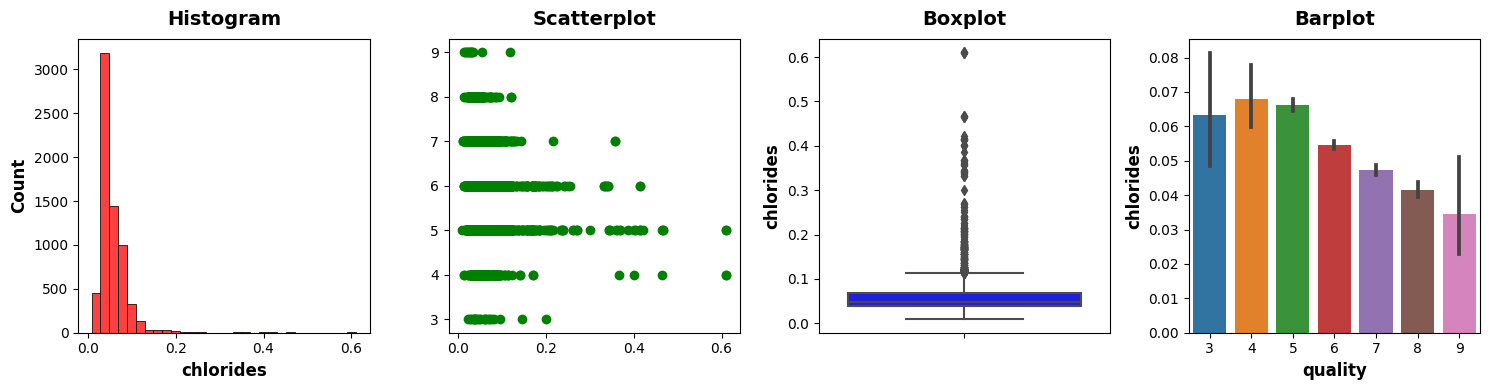

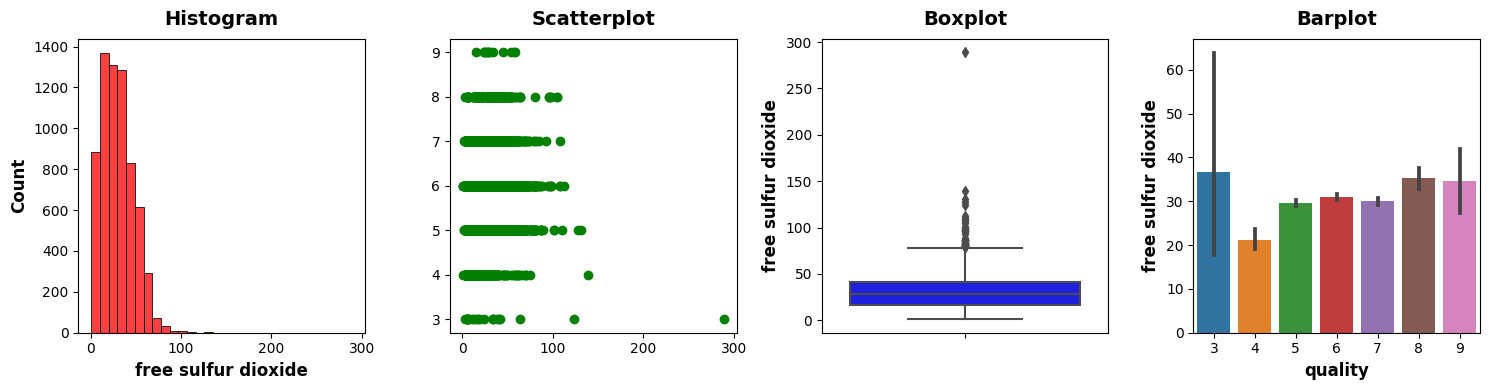

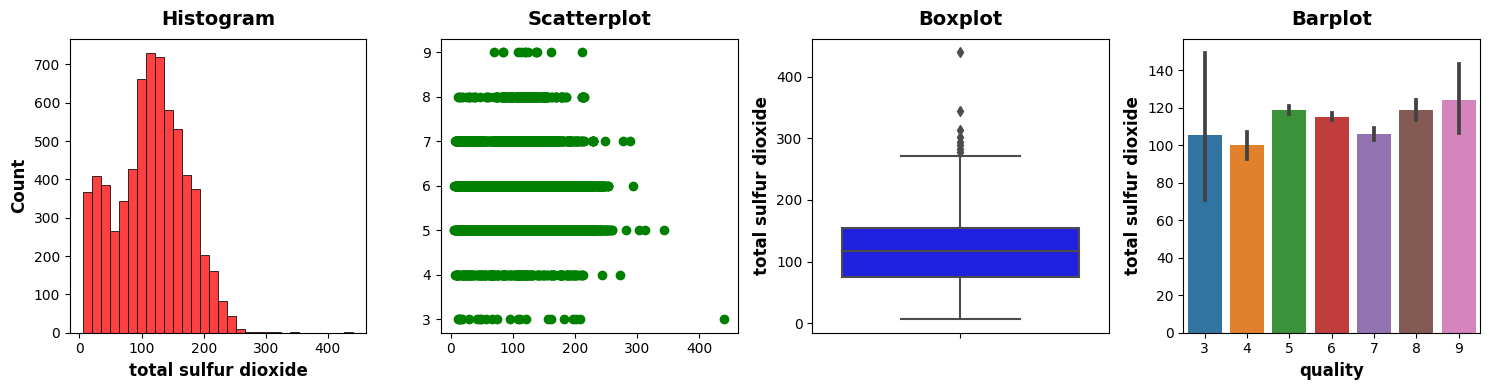

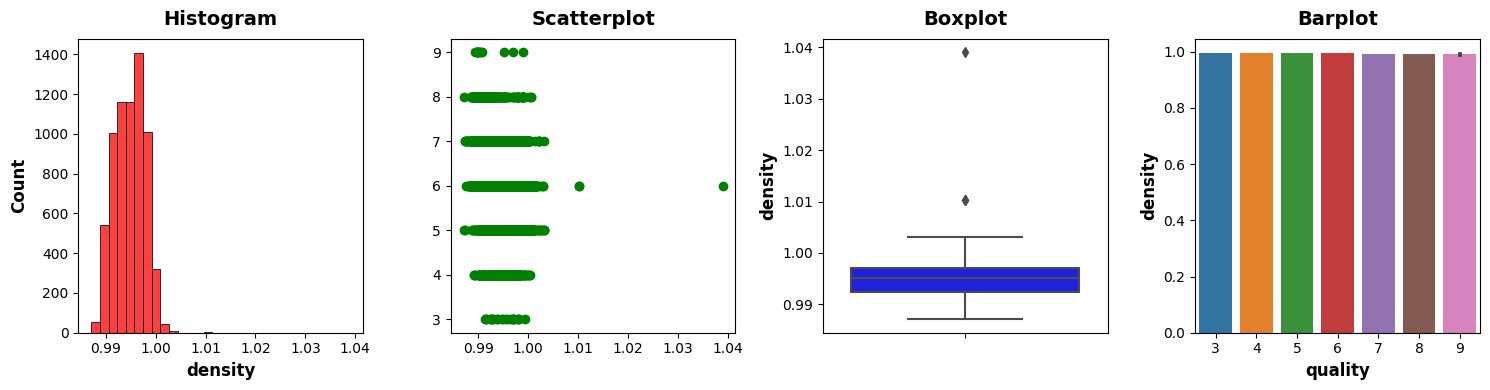

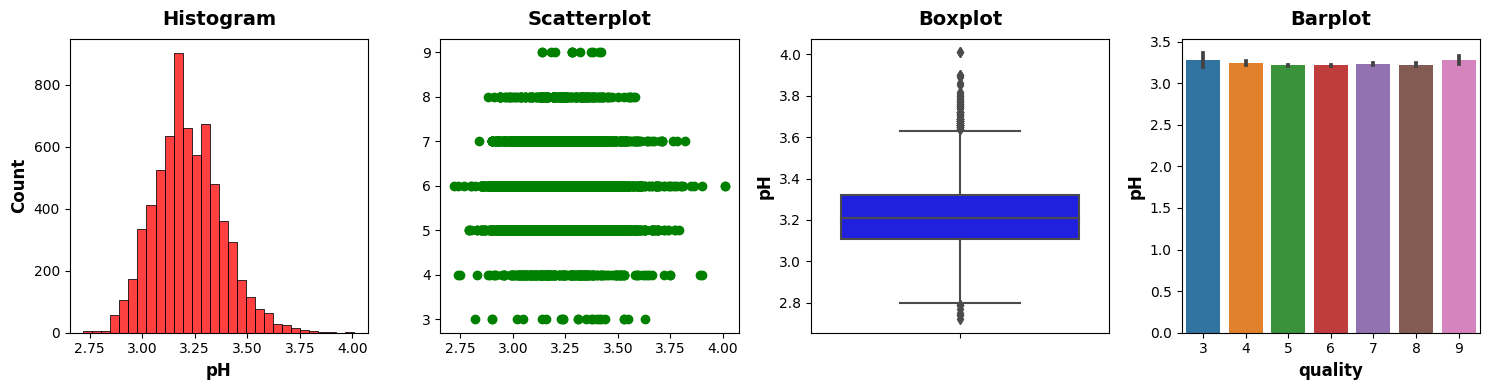

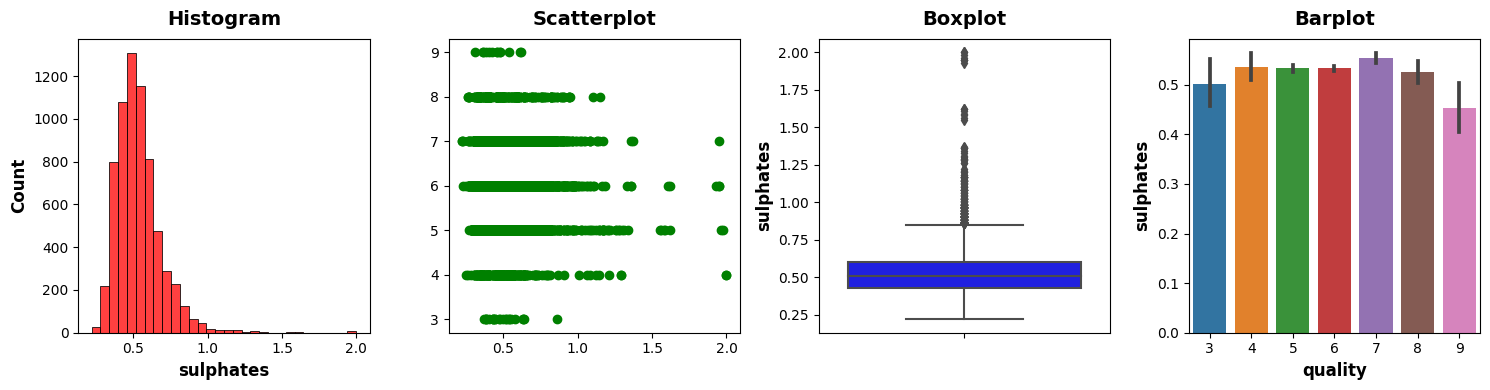

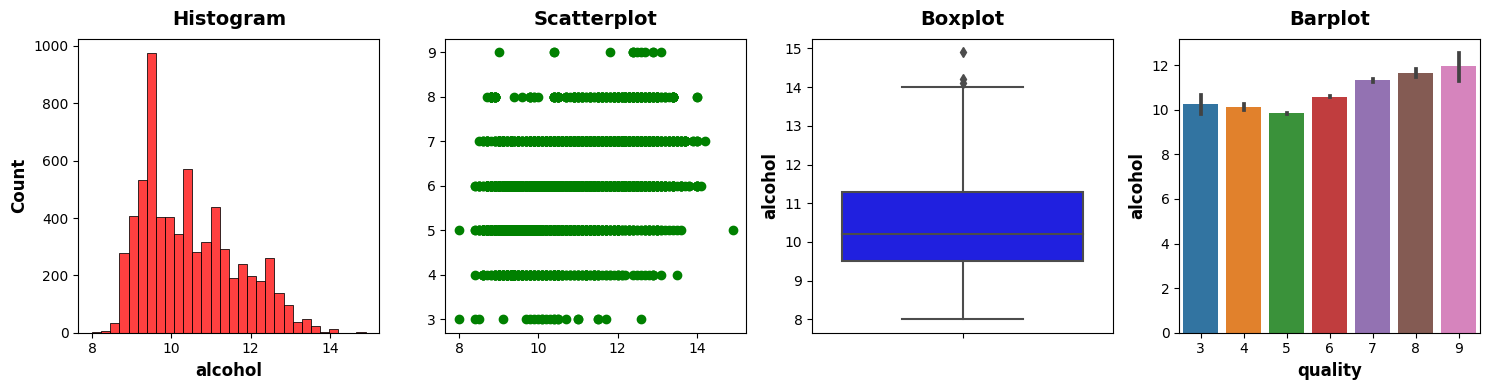

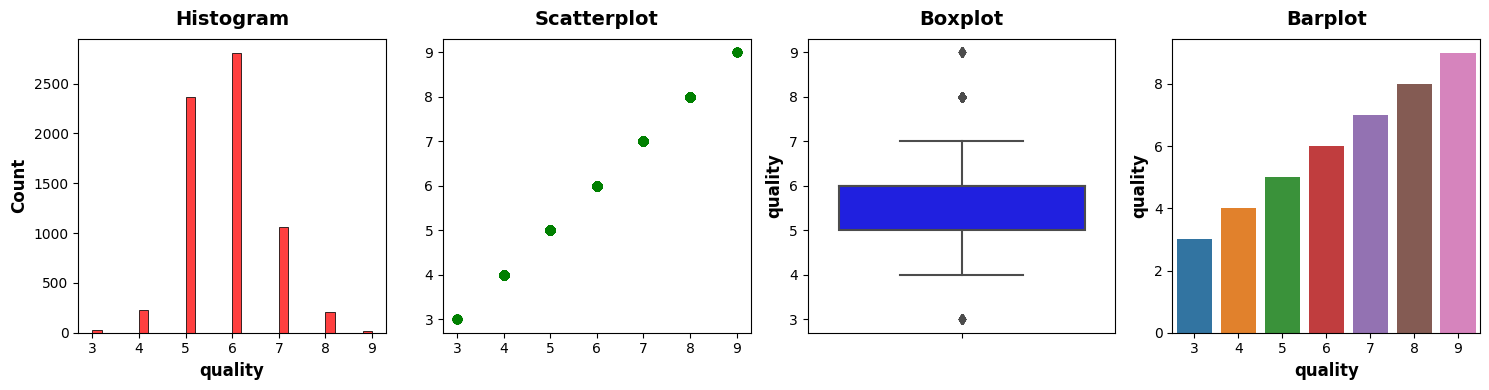

In [6]:
def diagnostic_plots(df, variable,target):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(15, 4))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], bins=30,color = 'r')
    plt.title('Histogram')


    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')
    
    
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')
    
    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    
    
    plt.show()
for variable in df.drop('type', axis = 1):
    diagnostic_plots(df,variable,'quality')

In [7]:
df.skew(axis = 0)

fixed acidity           1.770634
volatile acidity        1.357692
citric acid             0.498180
residual sugar          1.449472
chlorides               5.692030
free sulfur dioxide     1.169458
total sulfur dioxide    0.012788
density                 0.425231
pH                      0.416576
sulphates               2.157673
alcohol                 0.616383
quality                 0.333877
dtype: float64

In [8]:
df.kurtosis(axis = 0)

fixed acidity            5.214376
volatile acidity         2.183113
citric acid              2.240237
residual sugar           4.350428
chlorides               53.779375
free sulfur dioxide      7.556816
total sulfur dioxide    -0.461114
density                  6.075478
pH                       0.454295
sulphates               11.391954
alcohol                 -0.497568
quality                  0.267243
dtype: float64

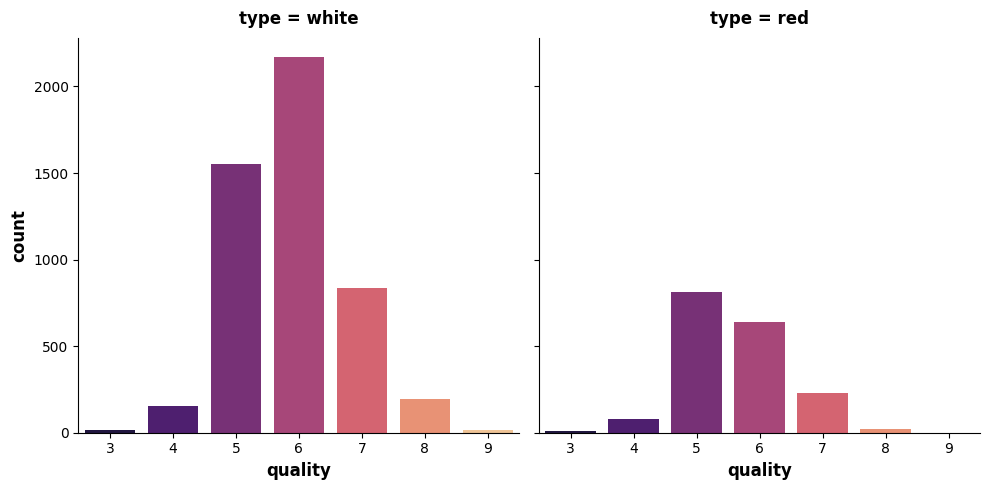

In [9]:
sns.catplot(x='quality', col = 'type', kind='count', data=df, palette = 'magma')


array([[<AxesSubplot: title={'center': 'fixed acidity'}>,
        <AxesSubplot: title={'center': 'volatile acidity'}>,
        <AxesSubplot: title={'center': 'citric acid'}>],
       [<AxesSubplot: title={'center': 'residual sugar'}>,
        <AxesSubplot: title={'center': 'chlorides'}>,
        <AxesSubplot: title={'center': 'free sulfur dioxide'}>],
       [<AxesSubplot: title={'center': 'total sulfur dioxide'}>,
        <AxesSubplot: title={'center': 'density'}>,
        <AxesSubplot: title={'center': 'pH'}>],
       [<AxesSubplot: title={'center': 'sulphates'}>,
        <AxesSubplot: title={'center': 'alcohol'}>,
        <AxesSubplot: title={'center': 'quality'}>]], dtype=object)

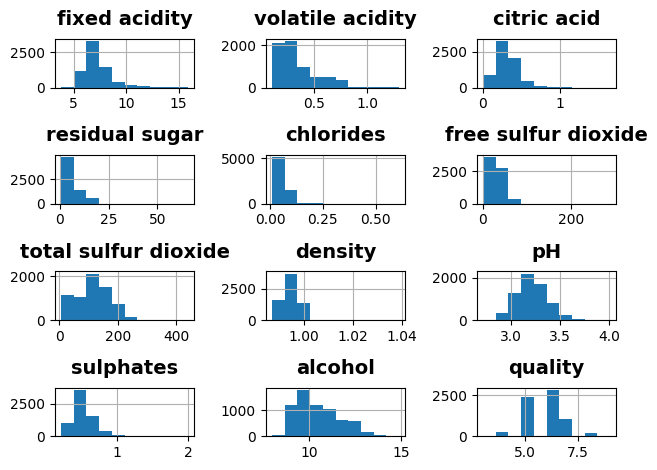

In [10]:
df.hist()

<AxesSubplot: >

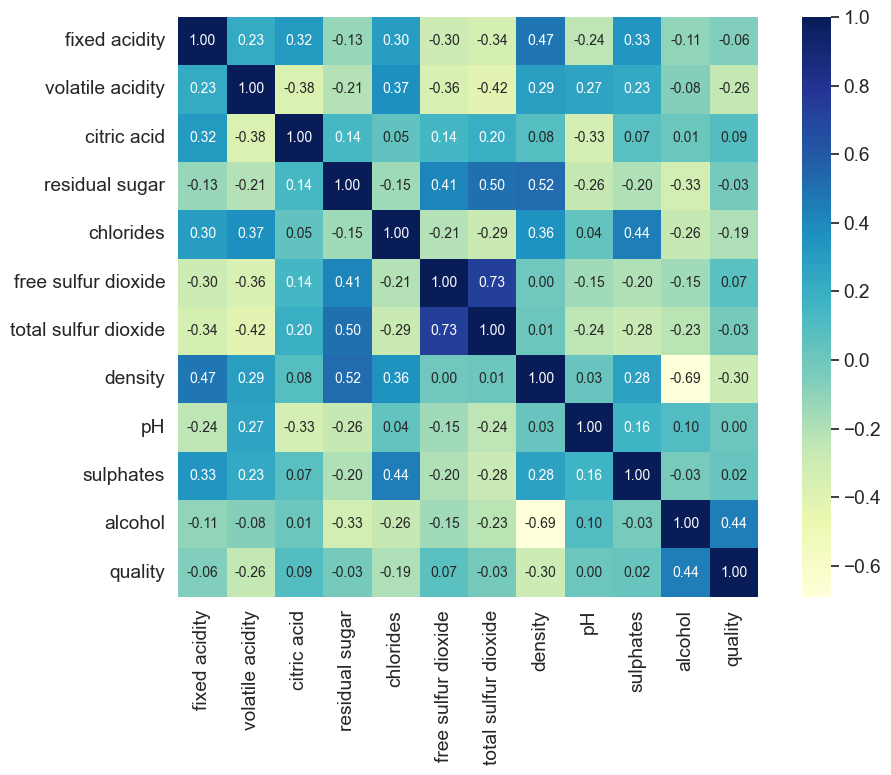

In [11]:
plt.figure(figsize = (10,8))
sns.set(font_scale=1.25)
sns.heatmap(df.corr(), cmap = 'YlGnBu', cbar_kws = {'shrink': 1}, annot = True, cbar = True, fmt = '.2f', annot_kws={'size': 10}, square = True) 

## Preprocessing


Both ColumnTransformer and Pipeline objects are simple transformer so they can be put inside each other. Thus can be loop further as neeeded

In [12]:
# The below code is creating a pipeline for each of the transformers.
transformer_cat = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
transformer_minmax = make_pipeline(MinMaxScaler(feature_range=(0, 1)))
transformer_std = make_pipeline(StandardScaler())
transformer_yeoj = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True))

In [13]:
'''features = df.columns.get_indexer(df.drop('type', axis = 1).columns.values).tolist()
features_cat = df.columns.get_indexer(['type']).tolist()
features_minmax = df.drop(['type', 'quality'], axis = 1).columns.values.tolist()
features_std = df.columns.get_indexer(['citric acid', 'total sulfur dioxide', 'density', 'pH']).tolist()
# get the index of the columns type and quality
a = df.columns.get_indexer(['type', 'quality'])
# get the index of the columns that are in both a and features std
b = np.concatenate((features_std, a))
# change ndarray to list
c = b.tolist()
# get the index of the columns that are not in c
d = df.drop(df.columns[c], axis = 1).columns.values
features_yeoj = df.columns.get_indexer(d).tolist()
features_minmax = df.columns.get_indexer(features_minmax).tolist()'''
features = list(df.drop('type', axis = 1).columns.values)
features_cat = ['type']
features_std = ['citric acid', 'total sulfur dioxide', 'density', 'pH']
features_yeoj = ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'sulphates', 'alcohol']
features_minmax = df.drop(['type', 'quality'], axis = 1).columns.values.tolist()

In [14]:
# Creating a pipeline that first transforms the data using the cols_transformer, then scales the data using the minmax scaler.
cat = make_column_transformer(
    (transformer_cat, features_cat),
    remainder='passthrough'
)

std = make_column_transformer(
    (transformer_std, features_std),
    remainder='passthrough'
)

yeoj = make_column_transformer(
    (transformer_yeoj, features_yeoj),
    remainder='passthrough'
)

minmax = make_column_transformer(
    (transformer_minmax, [i for i in range(10)]),
    remainder='passthrough'
)

cols_transformer = make_column_transformer(
    (transformer_yeoj, features_yeoj),
    (transformer_std, features_std), 
    (transformer_cat, features_cat)
)

# A custom transformer that prints the shape of the data and the first row of the data.
class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(X.shape)
        self.shape = X.shape
        # what other output you want
        print(X[0])
        return X

    def fit(self, X, y=None, **fit_params):
        return self
    
pipe = Pipeline(
    steps = [
        ("cols transformer", cols_transformer),
        ("min max scaler", minmax),
    ]
)

In [15]:
data = pd.DataFrame(pipe.fit_transform(df))

In [16]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.606863,0.468293,0.162999,0.432842,0.370402,0.640232,0.719488,0.216867,0.276498,0.073218,-1.301002,0.0,1.0
1,0.714004,0.705997,0.286871,0.680558,0.133051,0.648357,0.435048,0.156627,0.057604,0.183044,1.063286,1.0,0.0
2,0.765436,0.705997,0.403861,0.761440,0.240567,0.640232,0.347478,0.210843,0.278802,0.202312,0.067797,1.0,0.0
3,0.697224,0.605520,0.548710,0.542262,0.299979,0.436168,0.654814,0.198795,0.288018,0.136802,0.627760,0.0,1.0
4,0.582766,0.276299,0.843461,0.793549,0.328757,0.512494,0.323727,0.150602,0.347926,0.244701,-0.305512,0.0,1.0


In [17]:
data.columns = features_std + features_yeoj + ['red', 'white']
quality = df['quality']
# rearrange columns and add quality and type columns to the dataframe
data = pd.concat([data[df.drop(['type', 'quality'], axis = 1).columns.values.tolist()], 
                  quality, data.iloc[:,11:]], axis = 1)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,white
0,0.370402,0.640232,0.606863,0.719488,0.216867,0.276498,0.468293,0.162999,0.432842,0.073218,-1.301002,6,0.0,1.0
1,0.133051,0.648357,0.714004,0.435048,0.156627,0.057604,0.705997,0.286871,0.680558,0.183044,1.063286,5,1.0,0.0
2,0.240567,0.640232,0.765436,0.347478,0.210843,0.278802,0.705997,0.403861,0.761440,0.202312,0.067797,5,1.0,0.0
3,0.299979,0.436168,0.697224,0.654814,0.198795,0.288018,0.605520,0.548710,0.542262,0.136802,0.627760,6,0.0,1.0
4,0.328757,0.512494,0.582766,0.323727,0.150602,0.347926,0.276299,0.843461,0.793549,0.244701,-0.305512,5,0.0,1.0


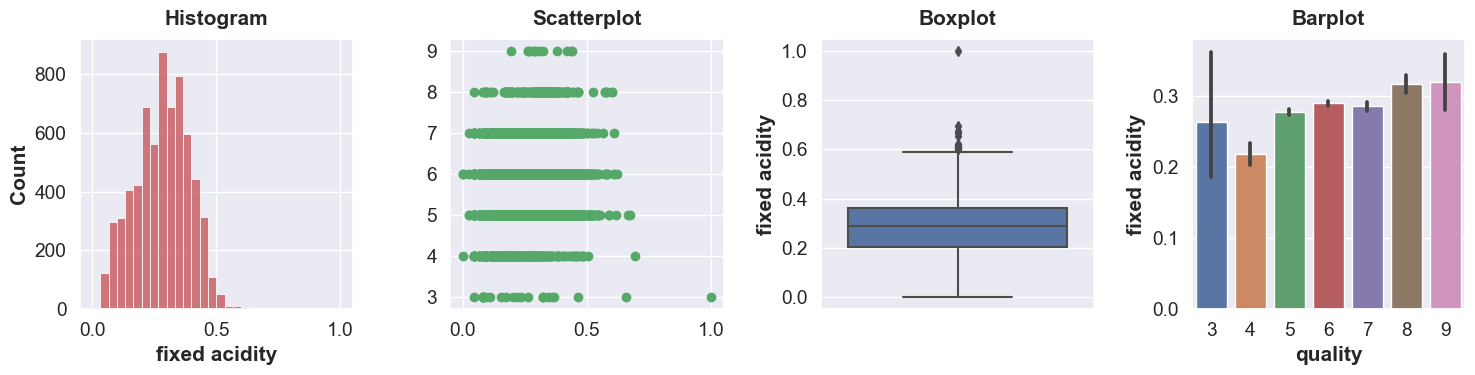

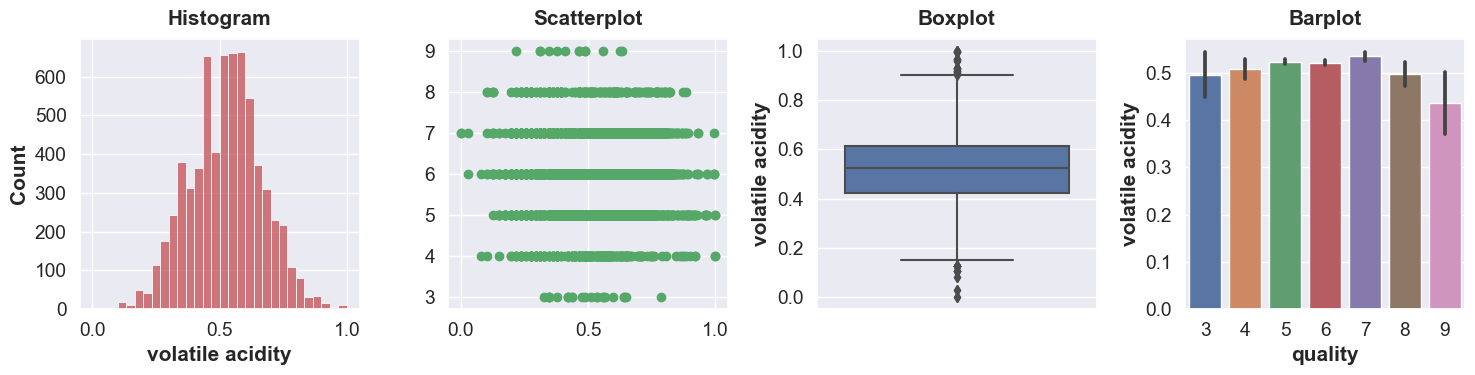

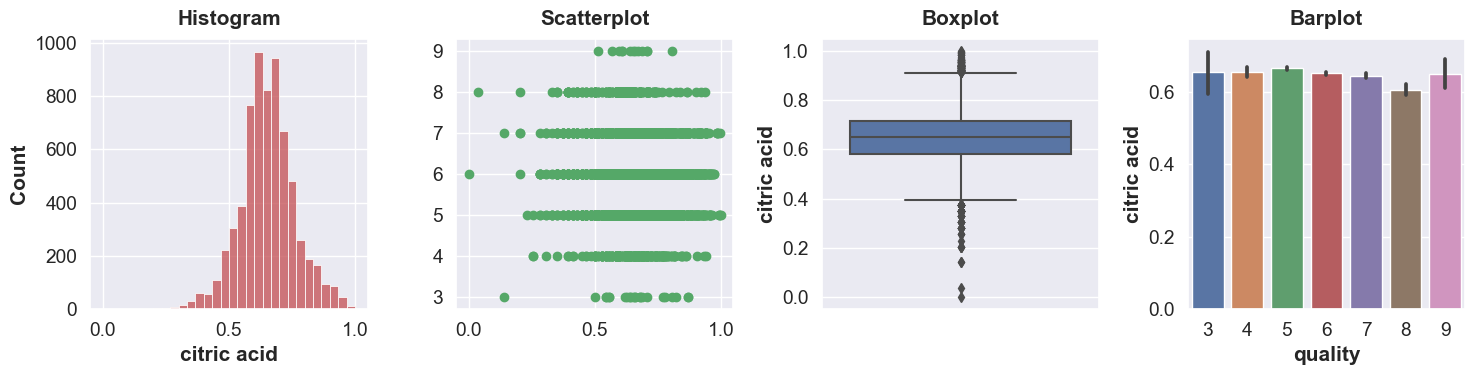

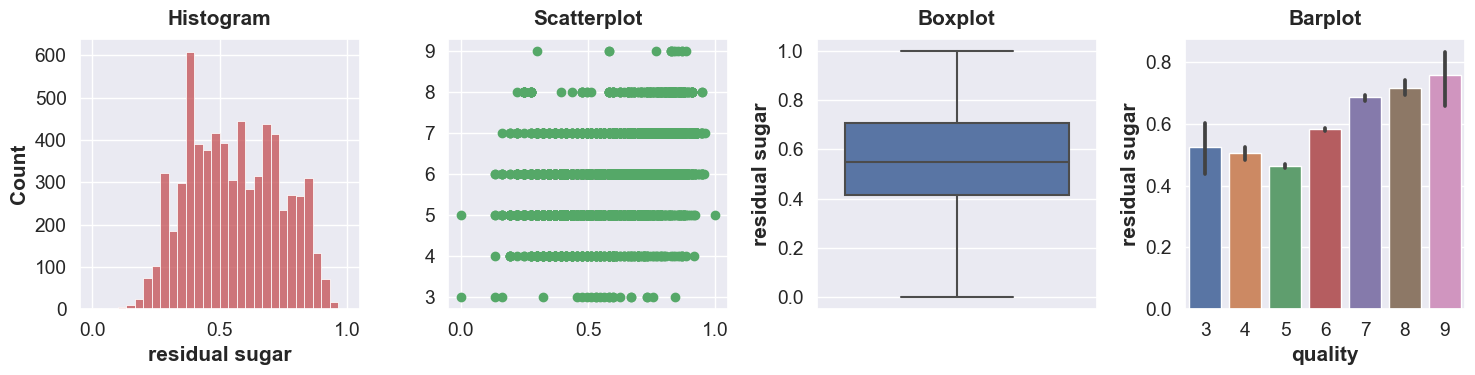

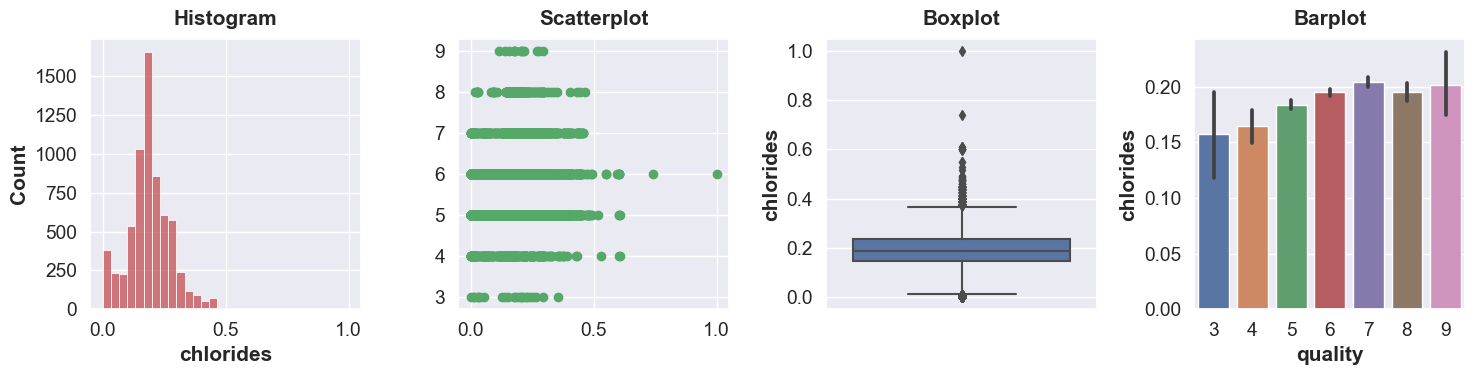

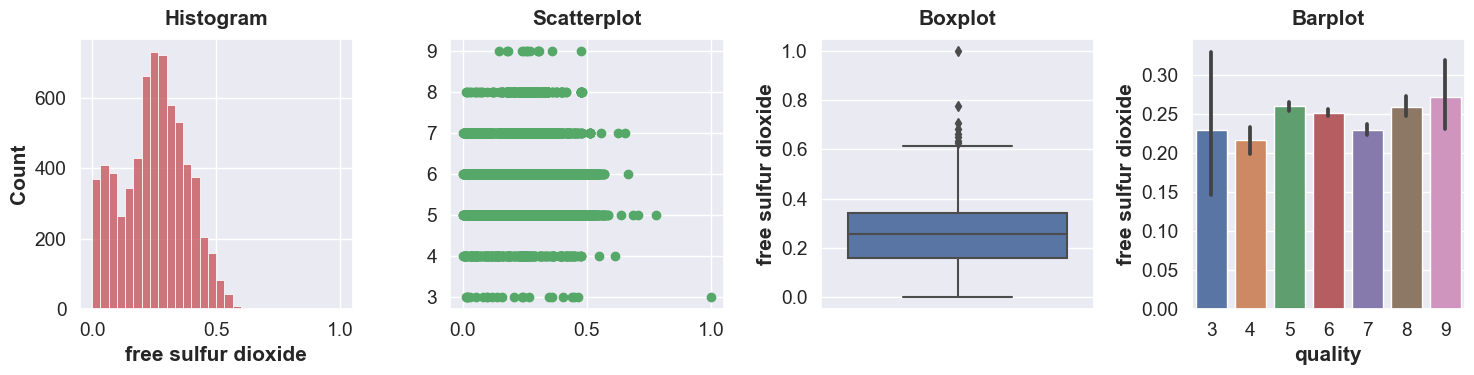

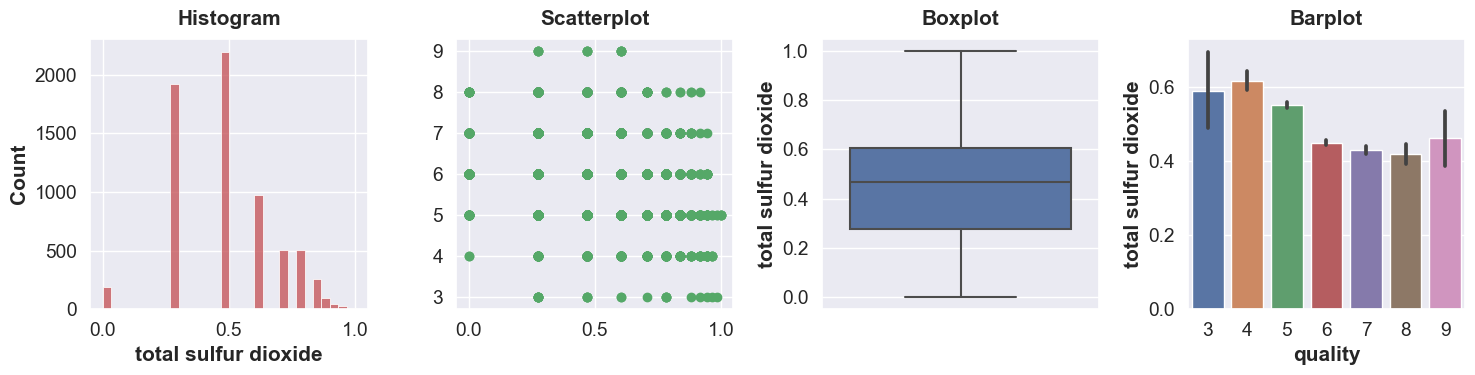

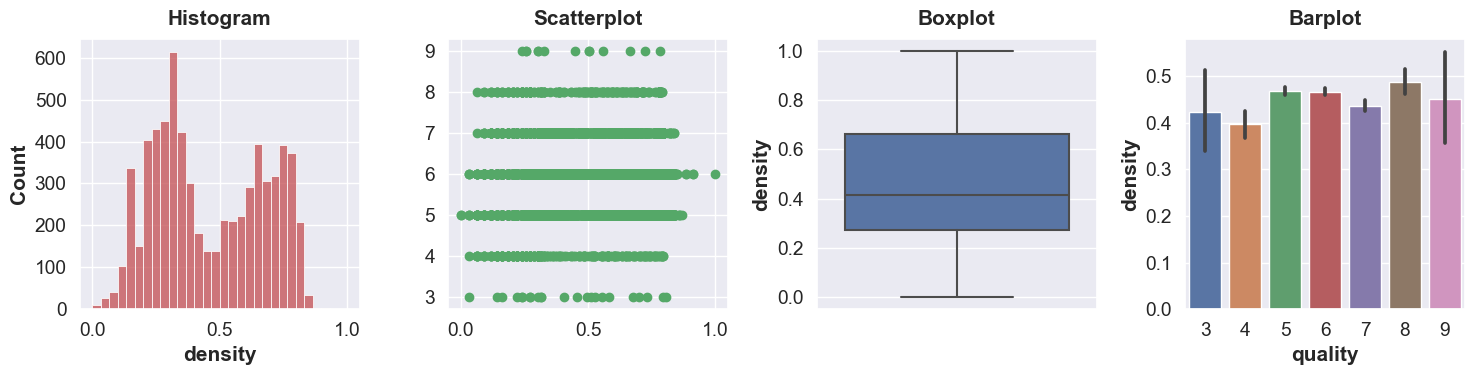

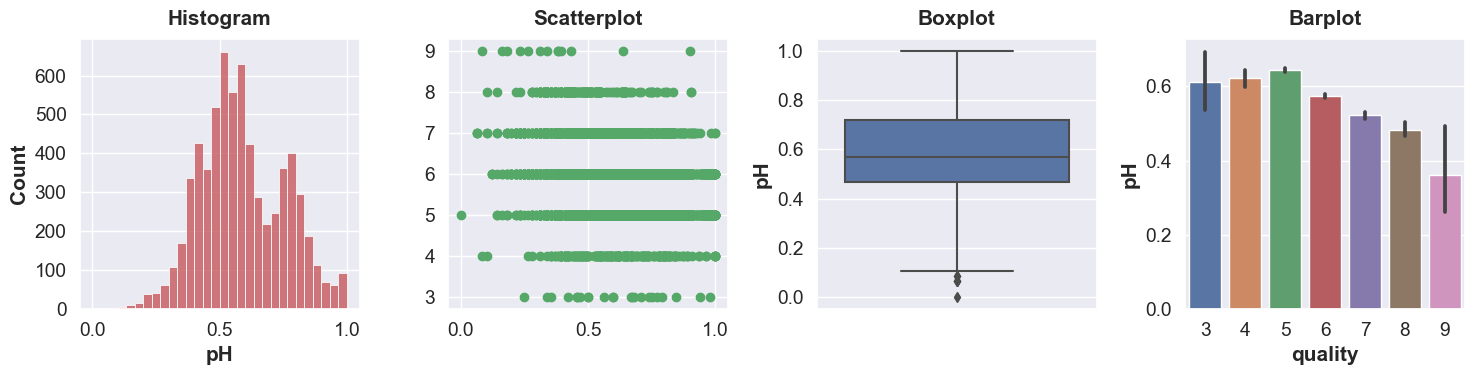

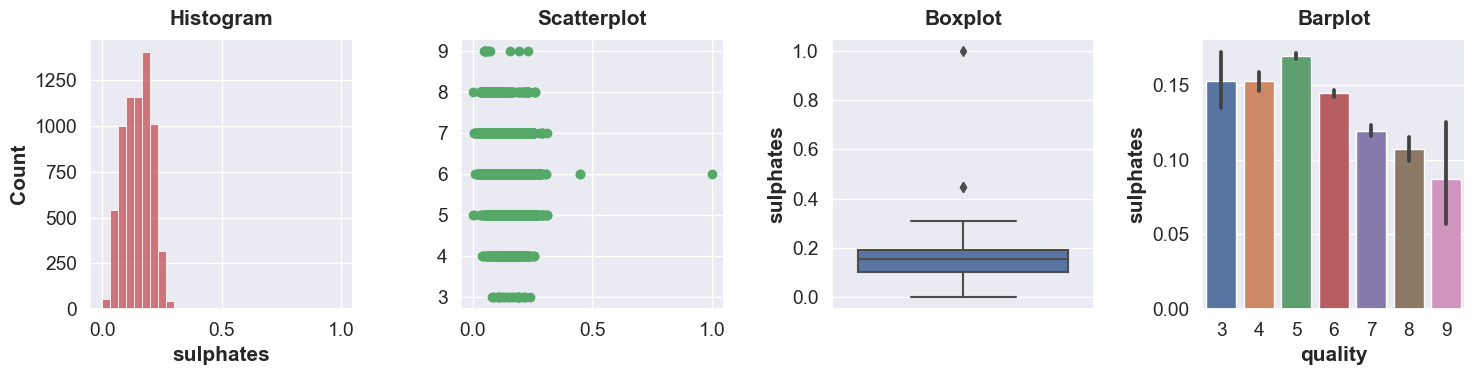

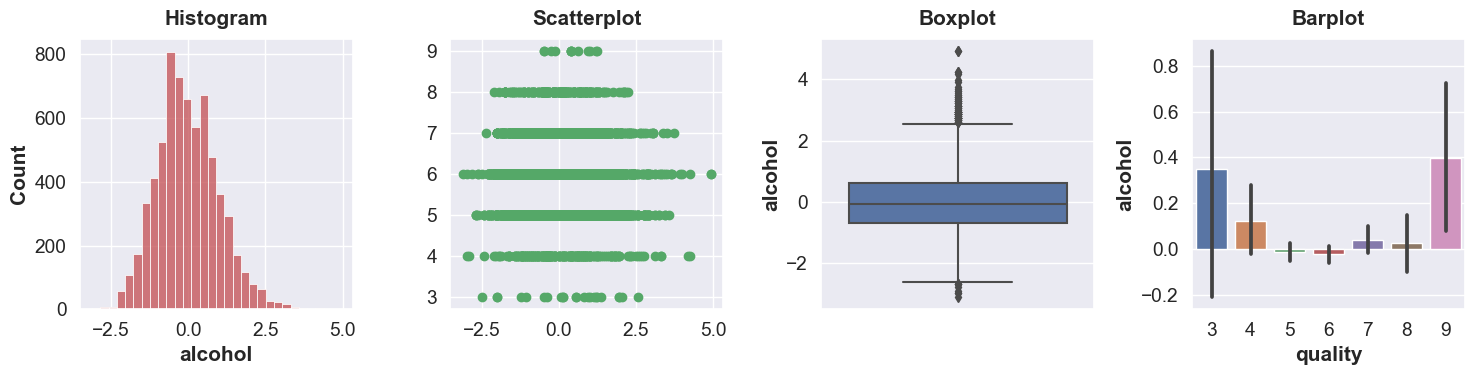

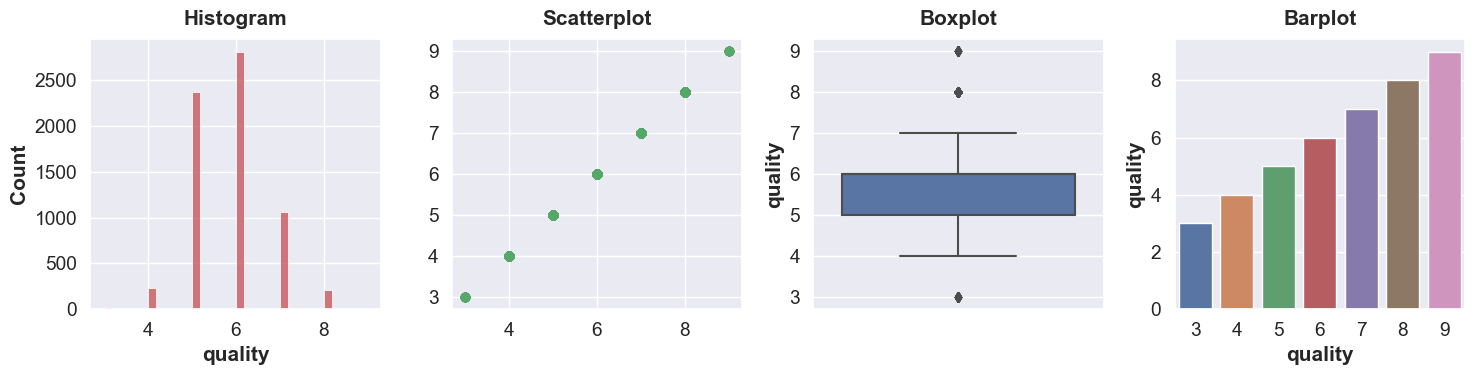

In [18]:
for variable in data.drop(['red', 'white'], axis = 1):
    diagnostic_plots(data,variable,'quality')

In [19]:
data.skew(axis = 0)

fixed acidity          -0.043244
volatile acidity        0.003573
citric acid            -0.066629
residual sugar          0.082693
chlorides               0.498180
free sulfur dioxide     0.012788
total sulfur dioxide    0.079676
density                 0.139869
pH                      0.212137
sulphates               0.425231
alcohol                 0.416576
quality                 0.333877
red                     1.063643
white                  -1.063643
dtype: float64

In [20]:
data.kurtosis(axis = 0)

fixed acidity          -0.229592
volatile acidity       -0.036140
citric acid             1.125537
residual sugar         -0.987359
chlorides               2.240237
free sulfur dioxide    -0.461114
total sulfur dioxide   -0.408276
density                -1.338934
pH                     -0.378842
sulphates               6.075478
alcohol                 0.454295
quality                 0.267243
red                    -0.868923
white                  -0.868923
dtype: float64

In [21]:
def split(data):
    """_summary_ : Split the data into train, validation and test sets.

    Args:
        data (DataFrame): Data to split

    Returns:
        DataFrame: train, validation and test sets  
    """
    train, val_and_test = train_test_split(data, test_size = 0.2, random_state=42)
    val, test = train_test_split(val_and_test, test_size = 0.5, random_state=42)
    return train, val, test

In [22]:
train, val, test = split(df)

In [23]:
train.shape, val.shape, test.shape

((5371, 13), (671, 13), (672, 13))

In [24]:
def split_target(data):
    """_summary_ : Splitting the data into features and target.

    Args:
        data (_type_): data to split

    Returns:
        _type_: features and target
    """
    # Splitting the data into features and target.
    X, y = data.drop('quality', axis = 1), data['quality']
    return X, y

def transform_features(X):
    """_summary_ : Transforming the features using the preprocessor.

    Args:
        X (_type_): features to transform

    Returns:
        _type_: transformed features
    """
    X_transform = pd.DataFrame(pipe.fit_transform(X))
    X_transform.columns = features_minmax + ['red', 'white']
    return X_transform 

def split_transform(data):
    '''Splitting the data into features and target, and then transforming the features.'''
    X, y = split_target(data)
    return transform_features(X), y

X_train, y_train = split_transform(train)
X_val, y_val = split_transform(val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5371, 13), (5371,), (671, 13), (671,))

In [25]:
X_train.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red,white
0,0.750054,0.840923,0.301025,0.839982,0.183918,0.688492,0.389941,0.138554,0.172811,0.196532,-0.194129,1.0,0.0
1,0.750054,0.784211,0.314538,0.727593,0.268568,0.721106,0.651897,0.060241,0.124424,0.179191,0.430111,1.0,0.0
2,0.616302,0.609243,0.548675,0.948980,0.399038,0.496128,0.389941,0.138554,0.320276,0.146435,-0.318978,0.0,1.0
3,0.712157,0.609243,0.521609,0.520110,0.317701,0.572322,0.804172,0.168675,0.221198,0.090559,-0.381402,0.0,1.0
4,0.703877,0.278857,0.831359,0.530191,0.311949,0.507926,0.367791,0.192771,0.430876,0.250482,-0.755946,0.0,1.0


In [26]:
X_val.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red,white
0,0.281660,0.627830,0.315859,0.240175,0.290771,0.385564,0.864963,0.170732,0.223776,0.133333,1.733281,0.0,1.0
1,0.612801,0.482751,0.780093,0.204759,0.487721,0.616370,0.897965,0.235772,0.405594,0.280000,-0.384072,0.0,1.0
2,0.687442,0.817230,0.579850,0.785182,0.400971,0.493095,0.326853,0.032520,0.129371,0.693333,0.765348,1.0,0.0
3,0.414225,0.282875,0.416676,0.515923,0.654542,0.672597,0.476215,0.195122,0.632867,0.506667,2.640717,0.0,1.0
4,0.635913,0.482751,0.430828,0.526609,0.446459,0.468421,0.240377,0.219512,0.493007,0.413333,-0.686550,0.0,1.0


# Define model


In [27]:
from keras.layers import Dense, Dropout, BatchNormalization

def build_model(hp):
    """_summary_ : Building a model using the hyperparameters.

    Args:
        hp (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Creating a placeholder for the input data.
    inputs = keras.Input(shape=(13,))
    x = Dense(units = hp.Int('units', min_value = 256, max_value = 1024, step = 32), activation = 'relu')(inputs)
    x = Dense(units = hp.Int('units', min_value = 256, max_value = 1024, step = 32), activation = 'relu')(x)
    x = Dropout(hp.Float('dropout', min_value = 0.0, max_value = 0.5, step = 0.1))(x)
    x = BatchNormalization()(x)
    x = Dense(units = hp.Int('units', min_value = 256, max_value = 1024, step = 32), activation = 'relu')(x)
    x = Dropout(hp.Float('dropout', min_value = 0.0, max_value = 0.5, step = 0.1))(x)
    x = BatchNormalization()(x)
    x = Dense(units = hp.Int('units', min_value = 256, max_value = 1024, step = 32), activation = 'relu')(x)
    x = Dropout(hp.Float('dropout', min_value = 0.0, max_value = 0.5, step = 0.1))(x)
    x = BatchNormalization()(x)
    x = Dense(units = hp.Int('units', min_value = 256, max_value = 1024, step = 32), activation = 'relu')(x)
    x = Dropout(hp.Float('dropout', min_value = 0.0, max_value = 0.5, step = 0.1))(x)                                                          
    # Creating a dense layer with 1 unit.
    outputs = layers.Dense(1)(x)
    # Creating a model with the input and output layers.
    model = keras.Model(inputs, outputs)
    # Compile model
    model.compile(
        optimizer = keras.optimizers.Adam(
            hp.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log")
        ),
        loss = 'mse',
        metrics = [tf.keras.metrics.RootMeanSquaredError()],
    )
    return model

## Callbacks

In [28]:
early_stopping = callbacks.EarlyStopping(
    monitor = 'loss',
    patience = 10,
    restore_best_weights = True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    monitor = 'loss',
    patience = 5,
    factor = 0.2,
)

In [29]:
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir = './logs')

# Hyperband

In [30]:
import keras_tuner as kt
from kerastuner.tuners import Hyperband

tuner = Hyperband(
    build_model,
    objective='val_loss',
    executions_per_trial=2,
    overwrite=True,
    directory='my_dir',
    project_name = 'wine_quality'
)

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [32]:
tuner.search(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks = [early_stopping, lr_schedule])

Trial 3 Complete [00h 00m 23s]
val_loss: 0.6992167830467224

Best val_loss So Far: 0.6992167830467224
Total elapsed time: 00h 01m 01s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
608               |928               |units
0.5               |0                 |dropout
0.0004401         |0.0008901         |lr
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
168/168 [==============================] - 4s 17ms/step - loss: 5.7952 - root_mean_squared_error: 2.4073 - val_loss: 1.5988 - val_root_mean_squared_error: 1.2645 - lr: 4.4010e-04
Epoch 2/2
168/168 [==============================] - 3s 17ms/step - loss: 2.3362 - root_mean_squared_error: 1.5285 - val_loss: 0.9740 - val_root_mean_squared_error: 0.9869 - lr: 4.4010e-04
Epoch 1/2
168/168 [==============================] - 3s 14ms/step

KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(x_test, y_test)
print(accuracy)

# Predict test dataset